In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=4102e580f58feea28e20030074874d30f2ae99e2fb7f00d64e9e129df7a836c3
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("Fraud-Detection").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Google Drive/creditcard.csv", header=True, inferSchema=True)
df.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

In [ ]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
df.describe().show()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|

In [ ]:
df.count()

284807

In [ ]:
from pyspark.sql.functions import col, sum
missing_counts = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [ ]:
df.groupby("Class").count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



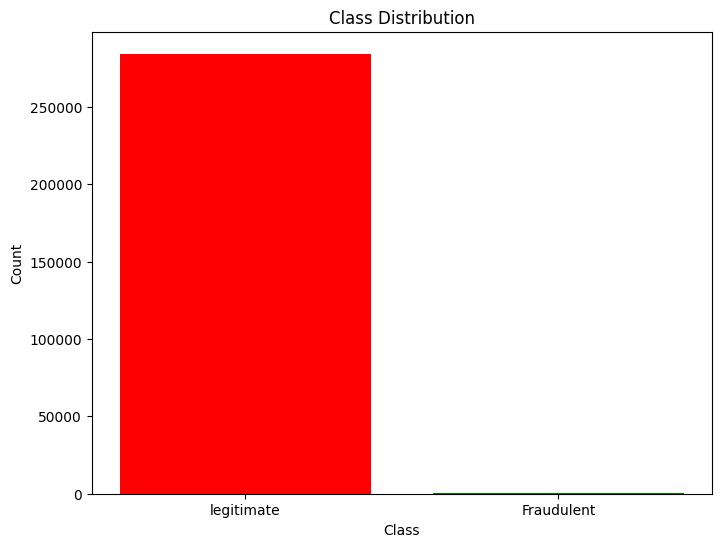

In [ ]:
import matplotlib.pyplot as plt
class_counts = df.groupBy("Class").count().toPandas()
plt.figure(figsize=(8, 6))
plt.bar(class_counts["Class"], class_counts["count"], color=['green', 'red'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(class_counts["Class"], ["Fraudulent", "legitimate"])
plt.show()


In [ ]:
minority_df = df.filter(col("Class") == 1)
majority_df = df.filter(col("Class") == 0)
ratio = minority_df.count() / majority_df.count()
undersampled_majority_df = majority_df.sample(False, ratio, seed=123)
balanced_df = undersampled_majority_df.union(minority_df)

In [ ]:
balanced_df.groupBy("Class").count().show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  471|
|    1|  492|
+-----+-----+



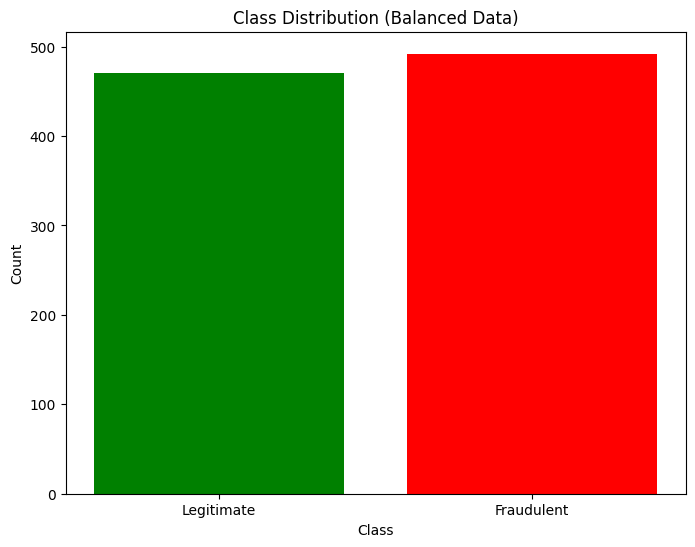

In [ ]:
balanced_class_counts = balanced_df.groupBy("Class").count().toPandas()
plt.figure(figsize=(8, 6))
plt.bar(balanced_class_counts["Class"], balanced_class_counts["count"], color=['green', 'red'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Balanced Data)")
plt.xticks(balanced_class_counts["Class"], ["Legitimate", "Fraudulent"])
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[col for col in balanced_df.columns if col != "Class"],
                           outputCol="features")
dataset = assembler.transform(balanced_df)

In [ ]:

dataset.show(5)

+------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------+-----+--------------------+
|  Time|               V1|                V2|               V3|               V4|                V5|                V6|                 V7|                 V8|                V9|                V10|               V11|              V12|                V13|               V14|               V15|                V16|               V17|               V18|               V19|               V20|               V21|              

In [ ]:
train_data, test_data = dataset.randomSplit([0.7, 0.3], seed=123)

RANDOM FOREST


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


rf = RandomForestClassifier(labelCol="Class", featuresCol="features")
model = rf.fit(train_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
predictions = model.transform(test_data)
auc_randomForest = evaluator.evaluate(predictions)
print("Area Under ROC:", auc_randomForest)

Area Under ROC: 0.935146773092475


In [ ]:
correct_predictions = predictions.filter(predictions["Class"] == predictions["prediction"]).count()
total_predictions = predictions.count()
accuracy = correct_predictions / total_predictions
print("Accuracy:", accuracy)


Accuracy: 0.9347826086956522


LOGISTIC REGRESSION


In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Class", featuresCol="features")
model = lr.fit(train_data)
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_regression = evaluator.evaluate(predictions)
print("Area Under ROC:", auc_regression)

Area Under ROC: 0.9277424775508061


DECISION TREE


In [ ]:

from pyspark.ml.classification import DecisionTreeClassifier
dt=DecisionTreeClassifier(labelCol="Class", featuresCol="features")
model=dt.fit(train_data)
predictions=model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_decision=evaluator.evaluate(predictions)
print("Area Under ROC: ",auc_decision)


Area Under ROC:  0.9385863571916191


GRADIENT_BOOSTED TREES


In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Class", featuresCol="features", maxIter=10)
gbtModel = gbt.fit(train_data)
predictions_gbt = gbtModel.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_gbt = evaluator.evaluate(predictions_gbt)
print("Area Under ROC (GBT without pipeline):", auc_gbt)


Area Under ROC (GBT without pipeline): 0.9349367221551227


LINEAR_SVC

In [ ]:
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(labelCol="Class", featuresCol="features", maxIter=10)
svcModel = svc.fit(train_data)
predictions_svc = svcModel.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_svc = evaluator.evaluate(predictions_svc)
print("Area Under ROC:", auc_svc)


Area Under ROC: 0.9314971380559787


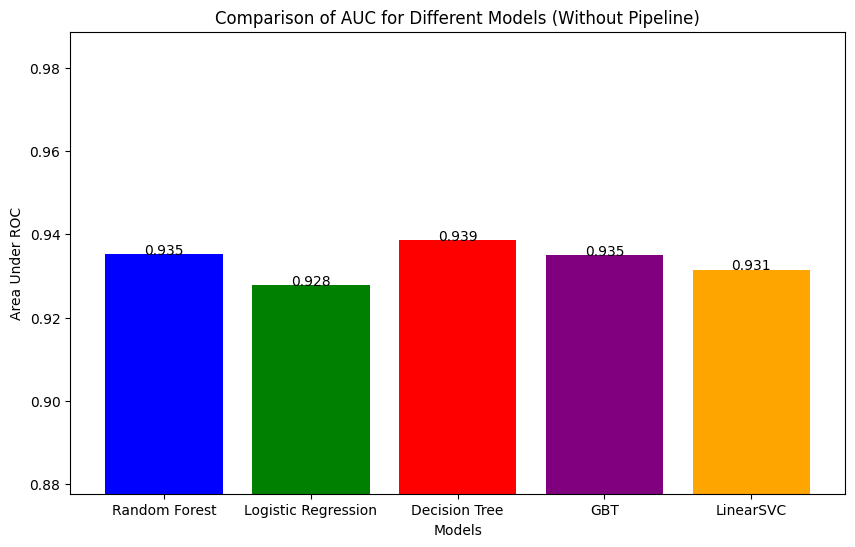

In [ ]:
import matplotlib.pyplot as plt

models = ['Random Forest', 'Logistic Regression', 'Decision Tree', 'GBT', 'LinearSVC']
auc_values_without_pipeline = [auc_randomForest, auc_regression, auc_decision, auc_gbt, auc_svc]


plt.figure(figsize=(10, 6))
plt.bar(models, auc_values_without_pipeline, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Models')
plt.ylabel('Area Under ROC')
plt.title('Comparison of AUC for Different Models (Without Pipeline)')
plt.ylim([min(auc_values_without_pipeline)-0.05, max(auc_values_without_pipeline)+0.05])
for i in range(len(auc_values_without_pipeline)):
    plt.text(i, auc_values_without_pipeline[i], round(auc_values_without_pipeline[i], 3), ha = 'center')
plt.show()


## USING PIPELINE

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

assembler1 = VectorAssembler(inputCols=[col for col in balanced_df.columns if col != "Class"], outputCol="features_pipeline")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

dt_model = DecisionTreeClassifier(labelCol="Class", featuresCol="features")
rf_model = RandomForestClassifier(labelCol="Class", featuresCol="features")
lr_model = LogisticRegression(labelCol="Class", featuresCol="features")

DECISION TREE WITH PIPELINE


In [ ]:

stages=[assembler1,scaler,dt_model]
pipeline=Pipeline(stages=stages)
final_pipeline = pipeline.fit(train_data)
test_predictions_from_pipeline = final_pipeline.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_decision_pipeline = evaluator.evaluate(predictions)
print(f"Area Under ROC",auc_decision_pipeline)

Area Under ROC 0.9385863571916191


LOGISTIC REGRESSION WITH PIPELINE

In [ ]:
stages=[assembler1,scaler,lr_model]
pipeline=Pipeline(stages=stages)
final_pipeline = pipeline.fit(train_data)
test_predictions_from_pipeline = final_pipeline.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_regression_pipeline = evaluator.evaluate(predictions)
print(f"Area Under ROC",auc_regression_pipeline)

Area Under ROC 0.9385863571916191


RANDOM FOREST WITH PIPELINE

In [ ]:
stages=[assembler1,scaler,rf_model]
pipeline=Pipeline(stages=stages)
final_pipeline = pipeline.fit(train_data)
test_predictions_from_pipeline = final_pipeline.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_random_pipeline = evaluator.evaluate(predictions)
print(f"Area Under ROC",auc_random_pipeline)

Area Under ROC 0.9385863571916191


GRADIENT_BOOSTED TREES WITH PIPELINE

In [ ]:

stages_gbt = [assembler1, scaler, gbt]
pipeline_gbt = Pipeline(stages=stages_gbt)
pipelineModel_gbt = pipeline_gbt.fit(train_data)
test_predictions_gbt = pipelineModel_gbt.transform(test_data)
auc_gbt_pipeline = evaluator.evaluate(test_predictions_gbt)
print("Area Under ROC:", auc_gbt_pipeline)


Area Under ROC: 0.9349367221551227


LINEAR SVC WITH PIPELINE

In [ ]:

stages_svc = [assembler1, scaler, svc]
pipeline_svc = Pipeline(stages=stages_svc)
pipelineModel_svc = pipeline_svc.fit(train_data)
test_predictions_svc = pipelineModel_svc.transform(test_data)

auc_svc_pipeline = evaluator.evaluate(test_predictions_svc)
print("Area Under ROC (SVM with pipeline):", auc_svc_pipeline)



Area Under ROC (SVM with pipeline): 0.9314971380559787


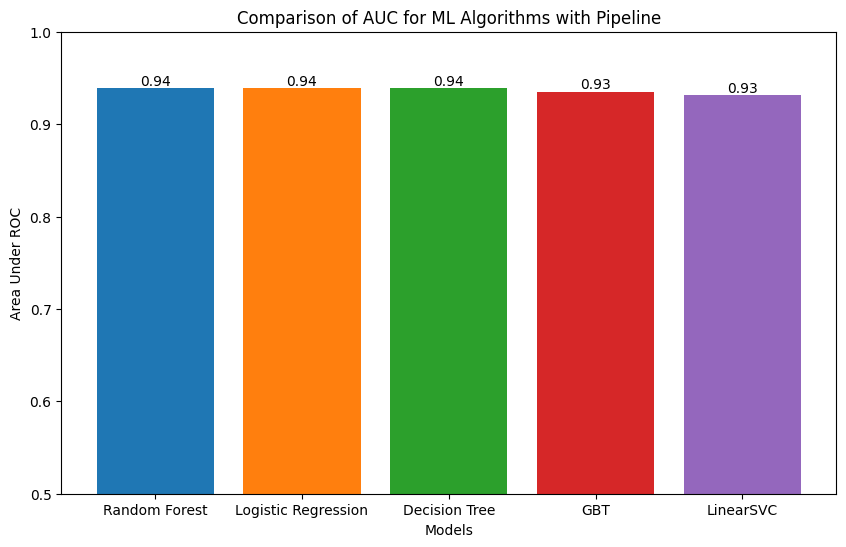

In [ ]:
models = ['Random Forest', 'Logistic Regression', 'Decision Tree', 'GBT', 'LinearSVC']
auc_scores_pipeline = [auc_random_pipeline, auc_regression_pipeline, auc_decision_pipeline, auc_gbt_pipeline, auc_svc_pipeline]


plt.figure(figsize=(10, 6))
plt.bar(models, auc_scores_pipeline, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.xlabel('Models')
plt.ylabel('Area Under ROC')
plt.title('Comparison of AUC for ML Algorithms with Pipeline')
plt.ylim([0.5, 1.0])
for i, score in enumerate(auc_scores_pipeline):
    plt.text(i, score, f"{score:.2f}", ha='center', va='bottom')
plt.show()

## HYPERPARAMETER TUNING


RANDOM FOREST


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid_rf = (ParamGridBuilder()
               .addGrid(rf.numTrees, [20, 50, 100])
               .addGrid(rf.maxDepth, [5, 10, 15])
               .addGrid(rf.minInfoGain, [0.0, 0.01])
               .build())

evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")


crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator,
                             numFolds=5)


cvModel_rf = crossval_rf.fit(train_data)

bestModel_rf = cvModel_rf.bestModel
print(bestModel_rf)
best_predictions_rf = bestModel_rf.transform(test_data)
best_auc_rf = evaluator.evaluate(best_predictions_rf)
print("Best AUC for Random Forest:", best_auc_rf)


RandomForestClassificationModel: uid=RandomForestClassifier_a3f25ad3554f, numTrees=50, numClasses=2, numFeatures=30
Best AUC for Random Forest: 0.9756340912671324


In [ ]:
best_num_trees = bestModel_rf.getOrDefault('numTrees')
best_max_depth = bestModel_rf.getOrDefault('maxDepth')

print("Best numTrees:", best_num_trees)
print("Best maxDepth:", best_max_depth)

Best numTrees: 50
Best maxDepth: 15


DESICION TREE

In [ ]:

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

dt = DecisionTreeClassifier(labelCol="Class", featuresCol="features")


paramGrid = ParamGridBuilder()
    .addGrid(dt.maxDepth, [5, 10, 20])
    .addGrid(dt.maxBins, [25, 35])
    .addGrid(dt.minInfoGain, [0.0, 0.01, 0.1])
    .addGrid(dt.minInstancesPerNode, [1, 2, 5])
    .build()


evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train_data)

bestModel_dt = cvModel.bestModel
print(bestModel_dt)
predictions = cvModel.transform(test_data)
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC: {auc}")


IndentationError: ignored

In [ ]:
best_max_depth = bestModel_dt.getOrDefault('maxDepth')
best_max_bins = bestModel_dt.getOrDefault('maxBins')
best_min_info_gain = bestModel_dt.getOrDefault('minInfoGain')
best_min_instances_per_node = bestModel_dt.getOrDefault('minInstancesPerNode')

print("Best maxDepth:", best_max_depth)
print("Best maxBins:", best_max_bins)
print("Best minInfoGain:", best_min_info_gain)
print("Best minInstancesPerNode:", best_min_instances_per_node)

LOGISTIC REGRESSION

In [ ]:

lr = LogisticRegression(labelCol="Class", featuresCol="features")

paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .addGrid(lr.regParam, [0.01, 0.1, 0.5])
                .build())

crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=evaluator,
                             numFolds=5)

cvModel_lr = crossval_lr.fit(train_data)
bestModel_lr = cvModel_lr.bestModel
print(bestModel_lr)
predictions = bestModel_lr.transform(test_data)
best_auc_lr = evaluator.evaluate(predictions)
print(f"Best AUC for LR: {best_auc_lr}")


In [ ]:

best_elastic_net_param = bestModel_lr.getOrDefault('elasticNetParam')
best_reg_param = bestModel_lr.getOrDefault('regParam')

print("Best elasticNetParam:", best_elastic_net_param)
print("Best regParam:", best_reg_param)


GRADIENT BOOSTED TREE

In [ ]:

gbt = GBTClassifier(labelCol="Class", featuresCol="features")

paramGrid_gbt = (ParamGridBuilder()
                 .addGrid(gbt.maxDepth, [2, 4, 6])
                 .addGrid(gbt.maxBins, [20, 32])
                 .addGrid(gbt.maxIter, [10, 20])
                 .build())


crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=5)

cvModel_gbt = crossval_gbt.fit(train_data)

bestModel_gbt = cvModel_gbt.bestModel
print(bestModel_gbt)
predictions = bestModel_gbt.transform(test_data)
best_auc_gbt = evaluator.evaluate(predictions)
print(f"Best AUC for GBT: {best_auc_gbt}")


In [ ]:
best_max_depth = bestModel_gbt.getOrDefault('maxDepth')
best_max_bins = bestModel_gbt.getOrDefault('maxBins')
best_max_iter = bestModel_gbt.getOrDefault('maxIter')

print("Best maxDepth:", best_max_depth)
print("Best maxBins:", best_max_bins)
print("Best maxIter:", best_max_iter)

LINEAR SVC

In [ ]:



paramGrid_svc = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [10, 50, 100])
                 .addGrid(svc.regParam, [0.01, 0.1, 0.5])
                 .build())


crossval_svc = CrossValidator(estimator=svc,
                              estimatorParamMaps=paramGrid_svc,
                              evaluator=evaluator,
                              numFolds=5)


cvModel_svc = crossval_svc.fit(train_data)


bestModel_svc = cvModel_svc.bestModel
print(bestModel_svc)
predictions = bestModel_svc.transform(test_data)
best_auc_svc = evaluator.evaluate(predictions)
print(f"Best AUC for SVC: {best_auc_svc}")


In [ ]:

best_max_iter = bestModel_svc.getOrDefault('maxIter')
best_reg_param = bestModel_svc.getOrDefault('regParam')

print("Best maxIter:", best_max_iter)
print("Best regParam:", best_reg_param)


In [ ]:

model_names = ['Random Forest', 'GBT', 'LinearSVC', 'Logistic Regression', 'Decision Tree']
auc_scores = [best_auc_rf, best_auc_gbt, best_auc_svc, best_auc_lr, auc]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bar = plt.bar(model_names, auc_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.xlabel('Models')
plt.ylabel('Area Under ROC')
plt.title('Comparison of AUC for Different Models After Hyperparameter Tuning')
plt.ylim([min(auc_scores) - 0.05, max(auc_scores) + 0.05])

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.4f}', ha='center', va='bottom')

plt.show()


In [ ]:
import matplotlib.pyplot as plt


auc_without_pipeline = [auc_randomForest, auc_gbt, auc_svc, auc_regression, auc_decision]
auc_with_pipeline = [auc_random_pipeline, auc_gbt_pipeline, auc_svc_pipeline, auc_regression_pipeline, auc_decision_pipeline]
auc_with_hyperparam_tuning = [best_auc_rf, best_auc_gbt, best_auc_svc, best_auc_lr, auc]

model_names = ['Random Forest', 'GBT', 'LinearSVC', 'Logistic Regression', 'Decision Tree']


plt.figure(figsize=(14, 7))


x_indexes = range(len(model_names))

plt.plot(x_indexes, auc_without_pipeline, label='Without Pipeline', marker='o')
plt.plot(x_indexes, auc_with_pipeline, label='With Pipeline', marker='s')
plt.plot(x_indexes, auc_with_hyperparam_tuning, label='With Hyperparameter Tuning', marker='^')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('Comparison of AUC Scores')

# Add legend
plt.legend()

# Set the position of the x ticks
plt.xticks(ticks=x_indexes, labels=model_names)

# Show the plot
plt.grid(True)
plt.show()
